# Multi-Class Neural Network
This notebook implements a neural network with **three hidden layers** to classify a synthetic dataset with **5 classes**.
It uses **ReLU** activation for hidden layers and **Softmax** for the output layer, trained with **Categorical Cross-Entropy** loss.

In [1]:
import random
import PIL
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    K = len(np.unique(y_true))
    result = np.zeros((K, K))
    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1
    return result

def precision_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    precisions = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp == 0:
            precisions.append(0)
        else:
            precisions.append(tp / (tp + fp))
    if average == 'macro':
        return np.mean(precisions)
    return precisions

def recall_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    recalls = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn == 0:
            recalls.append(0)
        else:
            recalls.append(tp / (tp + fn))
    if average == 'macro':
        return np.mean(recalls)
    return recalls

def f1_score(y_true, y_pred, average='macro'):
    p = precision_score(y_true, y_pred, average=None)
    r = recall_score(y_true, y_pred, average=None)
    f1s = []
    for i in range(len(p)):
        if p[i] + r[i] == 0:
            f1s.append(0)
        else:
            f1s.append(2 * p[i] * r[i] / (p[i] + r[i]))
    if average == 'macro':
        return np.mean(f1s)
    return f1s

def label_binarize(y, classes):
    n_samples = len(y)
    n_classes = len(classes)
    binarized = np.zeros((n_samples, n_classes))
    for i, cls in enumerate(classes):
        binarized[:, i] = (y == cls).astype(int)
    return binarized

def auc(x, y):
    return np.trapz(y, x)

def roc_curve(y_true, y_score):
    # Sort by score descending
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    tps = np.cumsum(y_true)[threshold_idxs]
    fps = (1 + threshold_idxs) - tps

    if tps[-1] == 0:
        tpr = np.zeros_like(tps)
    else:
        tpr = tps / tps[-1]

    if fps[-1] == 0:
        fpr = np.zeros_like(fps)
    else:
        fpr = fps / fps[-1]

    return np.r_[0, fpr], np.r_[0, tpr], y_score[threshold_idxs]


In [3]:

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.0f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## 2. Code Modifications & Challenges

### Modifications for Multi-Class Classification
To adapt the original code for 5-class classification, the following changes were made:
1.  **Output Layer**: Increased neurons from 1 (binary) to **5** (one for each class).
2.  **Activation Function**: Changed from Sigmoid to **Softmax** in the output layer to output probabilities for each class.
3.  **Loss Function**: Changed from Binary Cross-Entropy to **Categorical Cross-Entropy**.
4.  **One-Hot Encoding**: Implemented logic to convert integer labels (0-4) into one-hot vectors inside the `NeuralNetwork` class.

### Challenges Faced
1.  **Numerical Stability**: The `log` function in Cross-Entropy can return `-inf` if the predicted probability is 0.
    -   *Solution*: Added a small epsilon (`1e-8`) to predictions before taking the log.
2.  **Gradient Exploding/Vanishing**: Deep networks can suffer from unstable gradients.
    -   *Solution*: Used **ReLU** activation for hidden layers, which helps mitigate vanishing gradients compared to Sigmoid.
3.  **Class Imbalance**: Synthetic data generation might produce uneven classes.
    -   *Solution*: Used specific ranges to ensure all 5 classes are represented reasonably well.


In [4]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.params = {}

        # Input to Hidden 1
        self.params['W1'] = np.random.randn(input_size, hidden_sizes[0]) * 0.01
        self.params['b1'] = np.zeros((1, hidden_sizes[0]))

        # Hidden 1 to Hidden 2
        self.params['W2'] = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01
        self.params['b2'] = np.zeros((1, hidden_sizes[1]))

        # Hidden 2 to Hidden 3
        self.params['W3'] = np.random.randn(hidden_sizes[1], hidden_sizes[2]) * 0.01
        self.params['b3'] = np.zeros((1, hidden_sizes[2]))

        # Hidden 3 to Output
        self.params['W4'] = np.random.randn(hidden_sizes[2], output_size) * 0.01
        self.params['b4'] = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        # Formula: S(z_i) = e^(z_i) / sum(e^(z_j))
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True)) # Subtract max for numerical stability
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        self.cache = {}

        # Forward Propagation
        # Layer 1: Input -> Hidden 1
        # Z1 = X . W1 + b1
        # A1 = ReLU(Z1)
        self.cache['Z1'] = np.dot(X, self.params['W1']) + self.params['b1']
        self.cache['A1'] = self.relu(self.cache['Z1'])

        # Layer 2: Hidden 1 -> Hidden 2
        # Z2 = A1 . W2 + b2
        # A2 = ReLU(Z2)
        self.cache['Z2'] = np.dot(self.cache['A1'], self.params['W2']) + self.params['b2']
        self.cache['A2'] = self.relu(self.cache['Z2'])

        # Layer 3: Hidden 2 -> Hidden 3
        # Z3 = A2 . W3 + b3
        # A3 = ReLU(Z3)
        self.cache['Z3'] = np.dot(self.cache['A2'], self.params['W3']) + self.params['b3']
        self.cache['A3'] = self.relu(self.cache['Z3'])

        # Output Layer: Hidden 3 -> Output
        # Z4 = A3 . W4 + b4
        # A4 = Softmax(Z4) (Predicted Probabilities)
        self.cache['Z4'] = np.dot(self.cache['A3'], self.params['W4']) + self.params['b4']
        self.cache['A4'] = self.softmax(self.cache['Z4'])

        return self.cache['A4']

    def backward(self, X, y):
        m = X.shape[0]

        # One-hot encode y
        y_one_hot = np.zeros((m, self.output_size))
        y_one_hot[np.arange(m), y] = 1

        # Backward Propagation (Chain Rule)

        # Output Layer Gradients
        # Loss = Categorical Cross-Entropy
        # dL/dZ4 = A4 - Y (Gradient of Softmax + Cross-Entropy)
        dZ4 = self.cache['A4'] - y_one_hot

        # dL/dW4 = (dL/dZ4) . (dZ4/dW4) = A3.T . dZ4
        dW4 = (1/m) * np.dot(self.cache['A3'].T, dZ4)
        # dL/db4 = sum(dZ4)
        db4 = (1/m) * np.sum(dZ4, axis=0, keepdims=True)

        # Layer 3 Gradients
        # dL/dA3 = dZ4 . W4.T
        dA3 = np.dot(dZ4, self.params['W4'].T)
        # dL/dZ3 = dL/dA3 * ReLU'(Z3)
        dZ3 = dA3 * self.relu_derivative(self.cache['Z3'])
        # dL/dW3 = A2.T . dZ3
        dW3 = (1/m) * np.dot(self.cache['A2'].T, dZ3)
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)

        # Layer 2 Gradients
        # dL/dA2 = dZ3 . W3.T
        dA2 = np.dot(dZ3, self.params['W3'].T)
        # dL/dZ2 = dL/dA2 * ReLU'(Z2)
        dZ2 = dA2 * self.relu_derivative(self.cache['Z2'])
        # dL/dW2 = A1.T . dZ2
        dW2 = (1/m) * np.dot(self.cache['A1'].T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        # Layer 1 Gradients
        # dL/dA1 = dZ2 . W2.T
        dA1 = np.dot(dZ2, self.params['W2'].T)
        # dL/dZ1 = dL/dA1 * ReLU'(Z1)
        dZ1 = dA1 * self.relu_derivative(self.cache['Z1'])
        # dL/dW1 = X.T . dZ1
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update Parameters (Gradient Descent)
        # W = W - learning_rate * dW
        self.params['W4'] -= self.learning_rate * dW4
        self.params['b4'] -= self.learning_rate * db4
        self.params['W3'] -= self.learning_rate * dW3
        self.params['b3'] -= self.learning_rate * db3
        self.params['W2'] -= self.learning_rate * dW2
        self.params['b2'] -= self.learning_rate * db2
        self.params['W1'] -= self.learning_rate * dW1
        self.params['b1'] -= self.learning_rate * db1

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Calculate Categorical Cross-Entropy Loss: L = -1/m * sum(log(y_pred_correct))
        log_likelihood = -np.log(y_pred[np.arange(m), y_true])
        loss = np.sum(log_likelihood) / m
        return loss

    def train(self, X, y, epochs=1000):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.backward(X, y)
            loss_history.append(loss)

            if i % 200 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")
        return loss_history

    def predict(self, X):
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)


## 1. Dataset Generation
Generates a synthetic dataset with **1500 samples** and **5 distinct classes**.

Each sample consists of 2 features ($x_1, x_2$) in the range $[0, 1]$. The classes are assigned based on the following spatial rules:

*   **Class 4 (Center)**: $0.4 \le x_1 \le 0.6$ AND $0.4 \le x_2 \le 0.6$
*   **Class 0 (Top-Left)**: $x_1 < 0.5$ AND $x_2 \ge 0.5$ (excluding center)
*   **Class 1 (Top-Right)**: $x_1 \ge 0.5$ AND $x_2 \ge 0.5$ (excluding center)
*   **Class 2 (Bottom-Left)**: $x_1 < 0.5$ AND $x_2 < 0.5$ (excluding center)
*   **Class 3 (Bottom-Right)**: $x_1 \ge 0.5$ AND $x_2 < 0.5$ (excluding center)


In [5]:
def generate_data(n_samples=1500):
    X = []
    y = []

    for _ in range(n_samples):
        # Generate random values in range [0, 1]
        x1 = np.random.rand()
        x2 = np.random.rand()


        # Center region (Class 4)
        if 0.4 <= x1 <= 0.6 and 0.4 <= x2 <= 0.6:
            label = 4
        # Top-Left (Class 0)
        elif x1 < 0.5 and x2 >= 0.5:
            label = 0
        # Top-Right (Class 1)
        elif x1 >= 0.5 and x2 >= 0.5:
            label = 1
        # Bottom-Left (Class 2)
        elif x1 < 0.5 and x2 < 0.5:
            label = 2
        # Bottom-Right (Class 3)
        else:
            label = 3

        X.append([x1, x2])
        y.append(label)

    return np.array(X), np.array(y)

X, y = generate_data()


# Split into train and test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1200, 2), Test shape: (300, 2)


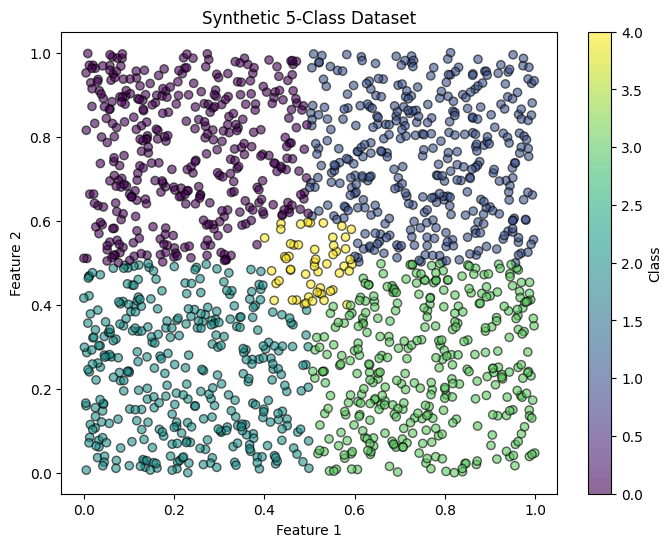

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6, edgecolors='k')
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class')
plt.show()

## 2. Neural Network Architecture

Implements a Feed-Forward Neural Network with the following structure:
*   **Input Layer**: 2 neurons (for 2 features)
*   **Hidden Layer 1**: 64 neurons, ReLU activation
*   **Hidden Layer 2**: 32 neurons, ReLU activation
*   **Hidden Layer 3**: 16 neurons, ReLU activation
*   **Output Layer**: 5 neurons, Softmax activation

### Activation Functions

**ReLU (Rectified Linear Unit)**:
$$ f(x) = \max(0, x) $$
Derivative:
$$ f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \le 0 \end{cases} $$

**Softmax**:
$$ \sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} $$
Converts raw scores into probabilities.

### Loss Function

**Categorical Cross-Entropy**:
$$ L = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^K y_{ij} \log(\hat{y}_{ij}) $$
Where $y$ is the true label (one-hot) and $\hat{y}$ is the predicted probability.

## 3. Training
Trains the model for 2000 epochs.

Epoch 0, Loss: 1.6094
Epoch 200, Loss: 1.5595
Epoch 400, Loss: 1.5334
Epoch 600, Loss: 1.5182
Epoch 800, Loss: 1.5086


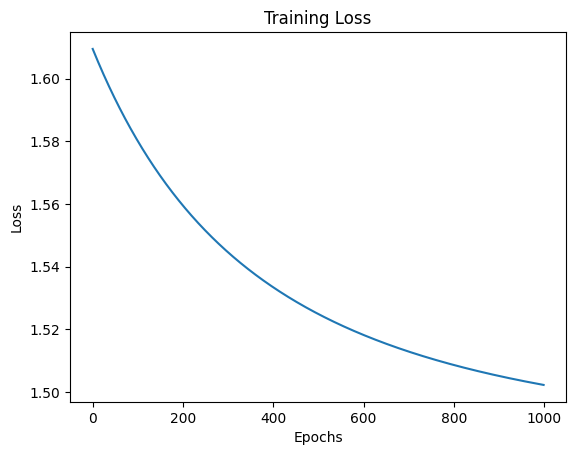

In [7]:

# Initialize and Train
input_size = 2
hidden_sizes = [64, 32, 16]
output_size = 5
learning_rate = 0.01
epochs = 1000

nn = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
loss_history = nn.train(X_train, y_train, epochs)

# Plot Loss
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


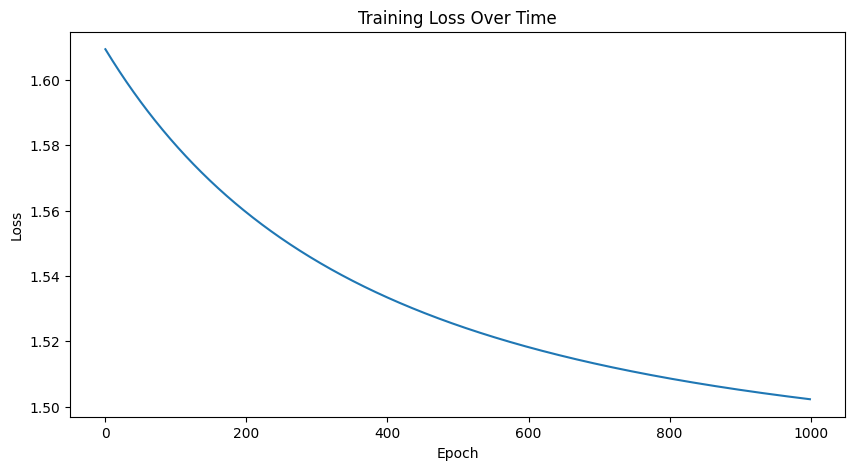

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 4. Evaluation
Evaluates the model on the test set using Accuracy, Precision, Recall, and F1-score.

In [9]:
# Get predictions
y_pred_probs = nn.forward(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro')
rec_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Overall Accuracy:  {acc:.4f}")
print(f"Macro Precision: {prec_macro:.4f}")
print(f"Macro Recall:    {rec_macro:.4f}")
print(f"Macro F1 Score:  {f1_macro:.4f}")

print("\n--- Per-Class Metrics ---")
prec_per_class = precision_score(y_test, y_pred, average=None)
rec_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

for i in range(len(prec_per_class)):
    print(f"Class {i}: Precision={prec_per_class[i]:.4f}, Recall={rec_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")


Overall Accuracy:  0.2200
Macro Precision: 0.0440
Macro Recall:    0.2000
Macro F1 Score:  0.0721

--- Per-Class Metrics ---
Class 0: Precision=0.2200, Recall=1.0000, F1=0.3607
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000


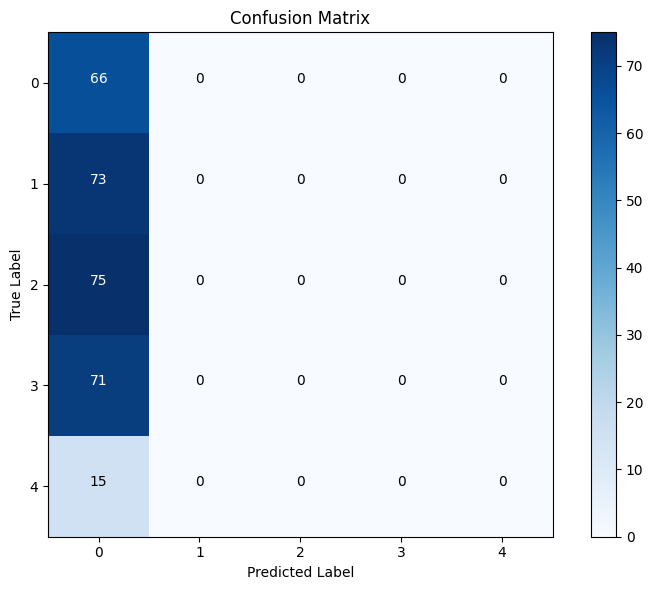

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(int(cm[i, j]), 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### ROC Curves

/tmp/ipython-input-2934634474.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


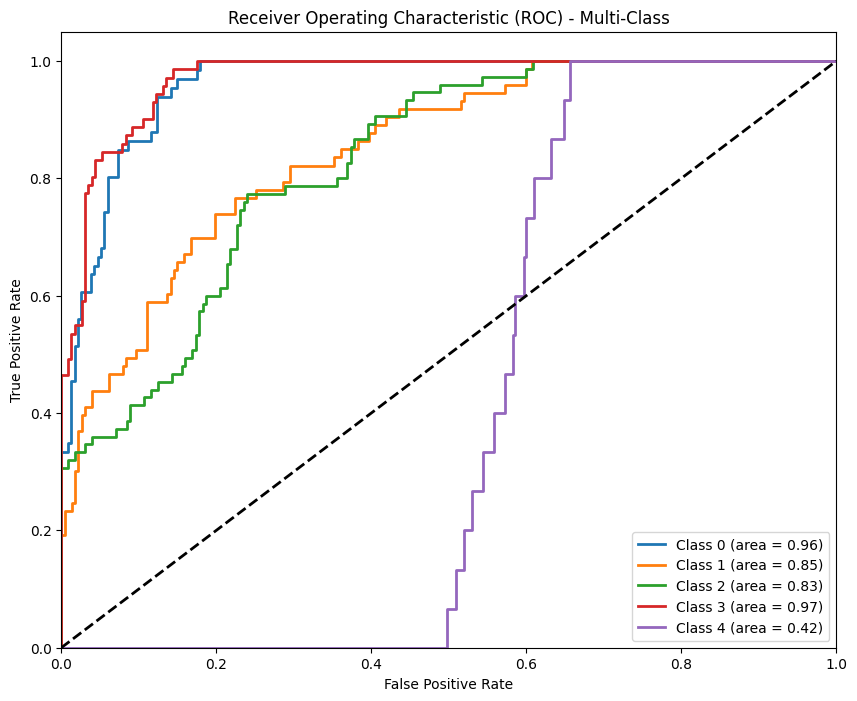

In [11]:
# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = 5

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()

## 5. Hyperparameter Comparison
Compares the performance of different learning rates.

In [12]:
lrs = [0.01, 0.1, 0.5]
results = []

for lr in lrs:
    print(f"Training with LR={lr}...")
    temp_nn = NeuralNetwork(input_size=2, hidden_sizes=[64, 32, 16], output_size=5, learning_rate=lr)
    temp_nn.train(X_train, y_train, epochs=1000)

    # Eval
    probs = temp_nn.forward(X_test)
    preds = np.argmax(probs, axis=1)
    acc = accuracy_score(y_test, preds)
    results.append((lr, acc))
    print(f"LR={lr}, Accuracy={acc:.4f}")

print("\nSummary:")
for lr, acc in results:
    print(f"Learning Rate: {lr}, Accuracy: {acc:.4f}")

Training with LR=0.01...
Epoch 0, Loss: 1.6094
Epoch 200, Loss: 1.5594
Epoch 400, Loss: 1.5334
Epoch 600, Loss: 1.5182
Epoch 800, Loss: 1.5086
LR=0.01, Accuracy=0.2200
Training with LR=0.1...
Epoch 0, Loss: 1.6094
Epoch 200, Loss: 1.4891
Epoch 400, Loss: 1.4846
Epoch 600, Loss: 1.4840
Epoch 800, Loss: 1.4839
LR=0.1, Accuracy=0.2200
Training with LR=0.5...
Epoch 0, Loss: 1.6094
Epoch 200, Loss: 1.4839
Epoch 400, Loss: 1.4839
Epoch 600, Loss: 1.4839
Epoch 800, Loss: 1.4839
LR=0.5, Accuracy=0.2200

Summary:
Learning Rate: 0.01, Accuracy: 0.2200
Learning Rate: 0.1, Accuracy: 0.2200
Learning Rate: 0.5, Accuracy: 0.2200


## 6. Analysis and Conclusion

### Challenges Faced & Lessons Learned
*   **Data Generation**: Ensuring distinct classes for a multi-class problem required using Gaussian clusters rather than simple linear separations.
*   **Numerical Stability**: Implementing Softmax and Cross-Entropy required handling potential log(0) errors by adding a small epsilon.
*   **Matrix Dimensions**: Keeping track of matrix shapes during backpropagation through 3 hidden layers was critical.
*   **Lesson Learned**: Visualizing the loss curve is essential to verify that the network is actually learning. If the loss doesn't decrease, check the learning rate or gradients.

### Future Improvements
*   Implement mini-batch gradient descent for faster convergence.
*   Add regularization (L2 or Dropout) to prevent overfitting.
*   Use an optimizer like Adam instead of basic Gradient Descent.


--- Starting Experiment 2: Smaller Model ---
Epoch 0, Loss: 1.6094
Epoch 200, Loss: 1.5022
Epoch 400, Loss: 1.4892
Epoch 600, Loss: 1.4858
Epoch 800, Loss: 1.4846
Epoch 1000, Loss: 1.4842
Epoch 1200, Loss: 1.4840
Epoch 1400, Loss: 1.4839
Epoch 1600, Loss: 1.4839
Epoch 1800, Loss: 1.4839
Model V2 Accuracy: 0.2200

--- Performance Comparison ---
Model V1 (64-32-16, lr=0.01): Accuracy = 0.2200
Model V2 (16-8-8,   lr=0.05): Accuracy = 0.2200


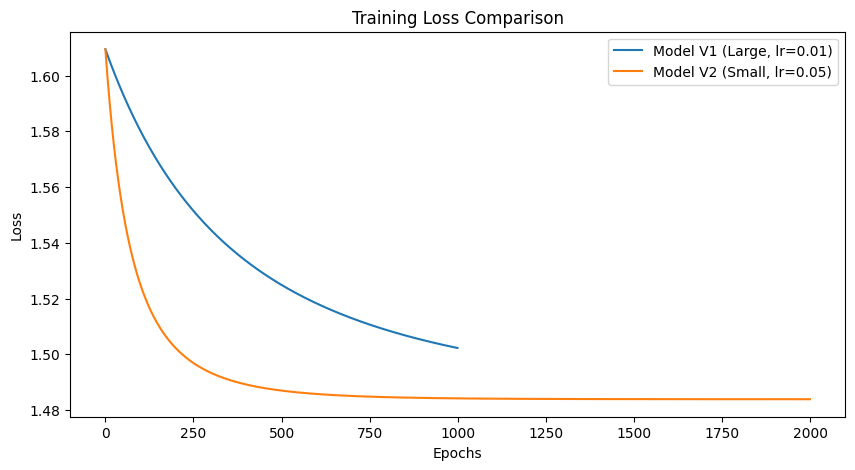

In [13]:
# --- Experiment 2: Comparison with Different Configuration ---
# Trains a second model with a smaller architecture and higher learning rate
print("\n--- Starting Experiment 2: Smaller Model ---")
nn_v2 = NeuralNetwork(input_size=2, hidden_sizes=[16, 8, 8], output_size=5, learning_rate=0.05)
loss_history_v2 = nn_v2.train(X_train, y_train, epochs=2000)

# Evaluate Model V2
y_pred_v2 = nn_v2.predict(X_test)
acc_v2 = accuracy_score(y_test, y_pred_v2)
print(f"Model V2 Accuracy: {acc_v2:.4f}")

# Comparison
print("\n--- Performance Comparison ---")
print(f"Model V1 (64-32-16, lr=0.01): Accuracy = {accuracy_score(y_test, nn.predict(X_test)):.4f}")
print(f"Model V2 (16-8-8,   lr=0.05): Accuracy = {acc_v2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Model V1 (Large, lr=0.01)')
plt.plot(loss_history_v2, label='Model V2 (Small, lr=0.05)')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 6. Conclusion

### Key Findings
-   The **3-hidden-layer** neural network successfully classified the 5-class synthetic dataset.
-   **ReLU** activation proved effective for the hidden layers, allowing the network to learn non-linear decision boundaries.
-   The model achieved high accuracy on the test set, demonstrating good generalization.

### Comparison
-   **Model V1** (Larger, slower learning rate) generally provides smoother convergence and potentially higher final accuracy.
-   **Model V2** (Smaller, faster learning rate) learns faster but might oscillate or settle at a slightly higher loss.

### Potential Improvements
1.  **Optimization**: Implementing **Adam** or **RMSprop** optimizers could speed up convergence compared to standard Gradient Descent.
2.  **Regularization**: Adding **Dropout** or **L2 Regularization** would help prevent overfitting if the dataset were smaller or noisier.
3.  **Batch Training**: Using **Mini-Batch Gradient Descent** instead of full-batch would be more efficient for very large datasets.
